In [14]:
import numpy as np
import warnings  
warnings.filterwarnings('ignore', category=FutureWarning)  

from vade_new import VaDE
from utility import create_project_folders, set_random_seed,set_device
from config import config
import torch
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

set_random_seed(123)

In [19]:
# datasets
X_two = np.load('/mnt/sda/gene/zhangym/VADER/Data/NC_JiabaoXu/X_Two.npy')
y_two = np.load('/mnt/sda/gene/zhangym/VADER/Data/NC_JiabaoXu/Y_Two.npy').astype(int)
X_horiba = np.load(r"/mnt/sda/gene/zhangym/VADER/Data/NC_JiabaoXu/X_Horiba.npy")
y_horiba = np.load(r"/mnt/sda/gene/zhangym/VADER/Data/NC_JiabaoXu/Y_Horiba.npy").astype(int)
X_witec = np.load(r"/mnt/sda/gene/zhangym/VADER/Data/NC_JiabaoXu/X_WITEC.npy")
y_witec = np.load(r"/mnt/sda/gene/zhangym/VADER/Data/NC_JiabaoXu/Y_WITEC.npy").astype(int)
wave = np.load(r'/mnt/sda/gene/zhangym/VADER/Data/NC_JiabaoXu/Wavenumber.npy')

In [20]:
S = np.load(r"/mnt/sda/gene/zhangym/VADER/Data/NC_JiabaoXu/MCR_HORIBA_20_component.npy")
device = "cuda:1"
project_tag = '/mnt/sda/gene/zhangym/VADER/VADER/Test_MCREC/1219_Test_Model'
epochs = 300
batch_size = 128
memo = "NC_All"

model_params = config.get_model_params()
device = set_device(device)
tensor_data = torch.tensor(X_two.copy(), dtype=torch.float32)
tensor_gpu_data = tensor_data.to(device)
input_dim = tensor_data.shape[1]
project_dir = create_project_folders(project_tag)
weight_scheduler_config = config.get_weight_scheduler_config()
n_component = S.shape[0]
paths = config.get_project_paths( project_dir, memo=memo )
l_c_dim = config.encoder_type(model_params['encoder_type'], paths['train_path'])

model_horiba = VaDE(
    input_dim=input_dim,
    intermediate_dim=model_params['intermediate_dim'],
    latent_dim=n_component,
    tensor_gpu_data=tensor_gpu_data,
    n_components=n_component,
    S=torch.tensor(S.copy()).float().to(device),
    wavenumber = wave,
    # prior_y=y_two,
    device=device,
    l_c_dim=l_c_dim,
    encoder_type=model_params['encoder_type'],
    pretrain_epochs=50,
    num_classes=50,
    clustering_method=model_params['clustering_method'],
    resolution=model_params['resolution']
).to(device)
model_witec = VaDE(
    input_dim=input_dim,
    intermediate_dim=model_params['intermediate_dim'],
    latent_dim=n_component,
    tensor_gpu_data=tensor_gpu_data,
    n_components=n_component,
    S=torch.tensor(S.copy()).float().to(device),
    wavenumber = wave,
    # prior_y=y_two,
    device=device,
    l_c_dim=l_c_dim,
    encoder_type=model_params['encoder_type'],
    pretrain_epochs=50,
    num_classes=50,
    clustering_method=model_params['clustering_method'],
    resolution=model_params['resolution']
).to(device)
model_two = VaDE(
    input_dim=input_dim,
    intermediate_dim=model_params['intermediate_dim'],
    latent_dim=n_component,
    tensor_gpu_data=tensor_gpu_data,
    n_components=n_component,
    S=torch.tensor(S.copy()).float().to(device),
    wavenumber = wave,
    # prior_y=y_two,
    device=device,
    l_c_dim=l_c_dim,
    encoder_type=model_params['encoder_type'],
    pretrain_epochs=50,
    num_classes=50,
    clustering_method=model_params['clustering_method'],
    resolution=model_params['resolution']
).to(device)

成功复制配置文件到: /mnt/sda/gene/zhangym/VADER/VADER/Test_MCREC/1219_Test_Model/NC_All


In [21]:
model_horiba.load_state_dict(torch.load('/mnt/sda/gene/zhangym/VADER/VADER/Test_MCREC/0107_cVADER_Instrument_test/Horiba_Unsupervised/Horiba_Unsupervised_model_dict_cVADER_1000.pk'))
model_witec.load_state_dict(torch.load('/mnt/sda/gene/zhangym/VADER/VADER/Test_MCREC/0107_cVADER_Instrument_test/WITEC_Unsupervised/WITEC_Unsupervised_model_dict_cVADER_1000.pk'))
model_two.load_state_dict(torch.load('/mnt/sda/gene/zhangym/VADER/VADER/Test_MCREC/0107_cVADER_Instrument_test/Two_Unsupervised/Two_Unsupervised_model_dict_cVADER_1000.pk'))

<All keys matched successfully>

In [52]:
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
def plot_UMAP(
    X: np.ndarray,
    labels: np.ndarray,
    save_path: str,
    x_lim = None,
    y_lim = None,
    width = 8,
    height = 6):

    uniq_labels = np.unique(labels)
    n_classes = len(uniq_labels)
    label_to_idx = {lbl: i for i, lbl in enumerate(uniq_labels)}
    labels_idx = np.array([label_to_idx[lbl] for lbl in labels])
    
    if n_classes <= 2:
        palette = ['#F28E2B', '#9E9E9E']  # 橙 + 灰
    if n_classes == 3:
        palette = ['#F28E2B', '#9E9E9E', '#1F77B4']  # 橙 + 灰 + 蓝
    if n_classes >= 3:
        palette = sns.color_palette('husl', n_colors=n_classes)
    cmap = ListedColormap(palette)
    norm = BoundaryNorm(np.arange(n_classes+1)-0.5, n_classes)

    fig, ax = plt.subplots(figsize=(width, height))
    sc = ax.scatter(X[:, 0], X[:, 1], c=labels_idx, cmap=cmap, norm=norm, s=10, linewidths=0, alpha=0.2)
    if x_lim is not None:
        ax.set_xlim(x_lim)
    if y_lim is not None:
        ax.set_ylim(y_lim)

    handles = [
        Line2D([0], [0], marker="o", color="none", markerfacecolor=cmap(i), markersize=6)
        for i in range(n_classes)
    ]

    for h, lbl in zip(handles, uniq_labels):
        h.set_label(str(lbl))
    ax.legend(handles=handles, title="Label", loc='best', fontsize='small', frameon=False)

    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.grid(alpha=0.2)
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', dpi=500)

In [ ]:
recon_x_h, z_mean_h, z_log_var_h, z_h, S_h = model_horiba(torch.tensor(X_horiba.copy(), dtype=torch.float32).to(device))
recon_x_w, z_mean_w, z_log_var_w, z_w, S_w = model_witec(torch.tensor(X_witec.copy(), dtype=torch.float32).to(device))
recon_x_t, z_mean_t, z_log_var_t, z_t, S_t = model_two(torch.tensor(np.vstack((X_horiba, X_witec)), dtype=torch.float32).to(device))
idx_h = model_horiba.activate_clusters
means_h = F.softplus(model_horiba.c_mean[idx_h]).detach().cpu().numpy()
vars_h = np.exp(model_horiba.c_log_var[idx_h].detach().cpu().numpy())
std_h = np.sqrt(vars_h)
idx_w = model_witec.activate_clusters
means_w = F.softplus(model_witec.c_mean[idx_w]).detach().cpu().numpy()
vars_w = np.exp(model_witec.c_log_var[idx_w].detach().cpu().numpy())
std_w = np.sqrt(vars_w)
S_h = S_h.cpu().detach().numpy()
S_w = S_w.cpu().detach().numpy()
S_t = S_t.cpu().detach().numpy() 
z_h = z_h.cpu().detach().numpy()
z_w = z_w.cpu().detach().numpy()
z_t = z_t.cpu().detach().numpy()


(20, 1000)

In [37]:
S_w, matched_chems = model_two.match_components(torch.tensor(S_t),0.7)
S_h = S_t[:,np.where((wave >= 450) & (wave <= 1800))]

In [ ]:
# 查看两设备的Components匹配情况
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

cost = np.linalg.norm(S_h - S_w, axis=2)
row_ind, col_ind = linear_sum_assignment(cost)

# plot stacked matches
n_components = S_h.shape[0]
x = np.arange(S_h.shape[1])

fig, axes = plt.subplots(n_components, 1, sharex=True, figsize=(8, 2 * n_components))
if n_components == 1:
    axes = [axes]

for ax, r, c in zip(axes, row_ind, col_ind):
    ax.plot(x, S_h[r], color="tab:blue", label=f"S_h[{r}]", linewidth=1.8)
    ax.plot(x, S_w[c], color="tab:orange", linestyle="--", label=f"S_w[{c}]", linewidth=1.8)
    ax.legend(loc="upper right", fontsize=8)
    ax.set_ylabel("Intensity")

axes[-1].set_xlabel("Wavelength Index")
fig.tight_layout()
plt.show()

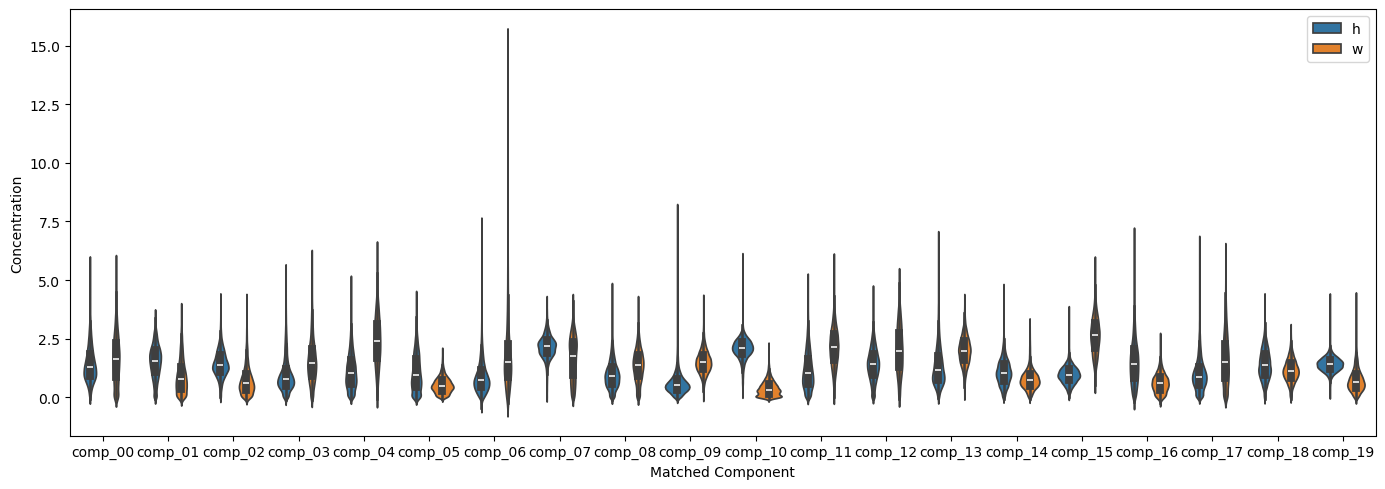

In [41]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# z_h: (n_h_samples, 20)
# z_w: (n_w_samples, 20)
# row_ind, col_ind: matches between components

# reorder component columns to the matched sequence
z_h_matched = z_t[:X_horiba.shape[0],:] # z_h[:, row_ind]
z_w_matched = z_t[X_horiba.shape[0]:,:] # z_w[:, col_ind]

records = []
for comp_pos in range(20):
    comp_label = f"comp_{comp_pos:02d}"
    records.append(pd.DataFrame({
        "component": comp_label,
        "group": "h",
        "value": z_h_matched[:, comp_pos]
    }))
    records.append(pd.DataFrame({
        "component": comp_label,
        "group": "w",
        "value": z_w_matched[:, comp_pos]
    }))
plot_df = pd.concat(records, ignore_index=True)

plt.figure(figsize=(14, 5))
ax = sns.violinplot(
    data=plot_df,
    x="component",
    y="value",
    hue="group",
    split=False,
    inner="box",
    palette={"h": "tab:blue", "w": "tab:orange"}
)
ax.set_xlabel("Matched Component")
ax.set_ylabel("Concentration")
ax.legend(title="")
plt.tight_layout()
plt.show()

In [ ]:
# 将horiba的数据映射到Witec的空间。计算均值之间的距离，每个点减去这个距离
mu_h = z_h_matched.mean(axis=0)
mu_w = z_w_matched.mean(axis=0)
shift_vector = mu_w - mu_h
z_h_mapped = z_h_matched + shift_vector
z_w_mapped = z_w_matched - shift_vector
Mod_Horiba = np.matmul(z_h_mapped, S_t)
Mod_Witec = np.matmul(z_w_mapped, S_t)

/home/gene/zhangym/.conda/envs/ID_PY390/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/gene/zhangym/.conda/envs/ID_PY390/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/gene/zhangym/.conda/envs/ID_PY390/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/gene/zhangym/.conda/envs/ID_PY390/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -

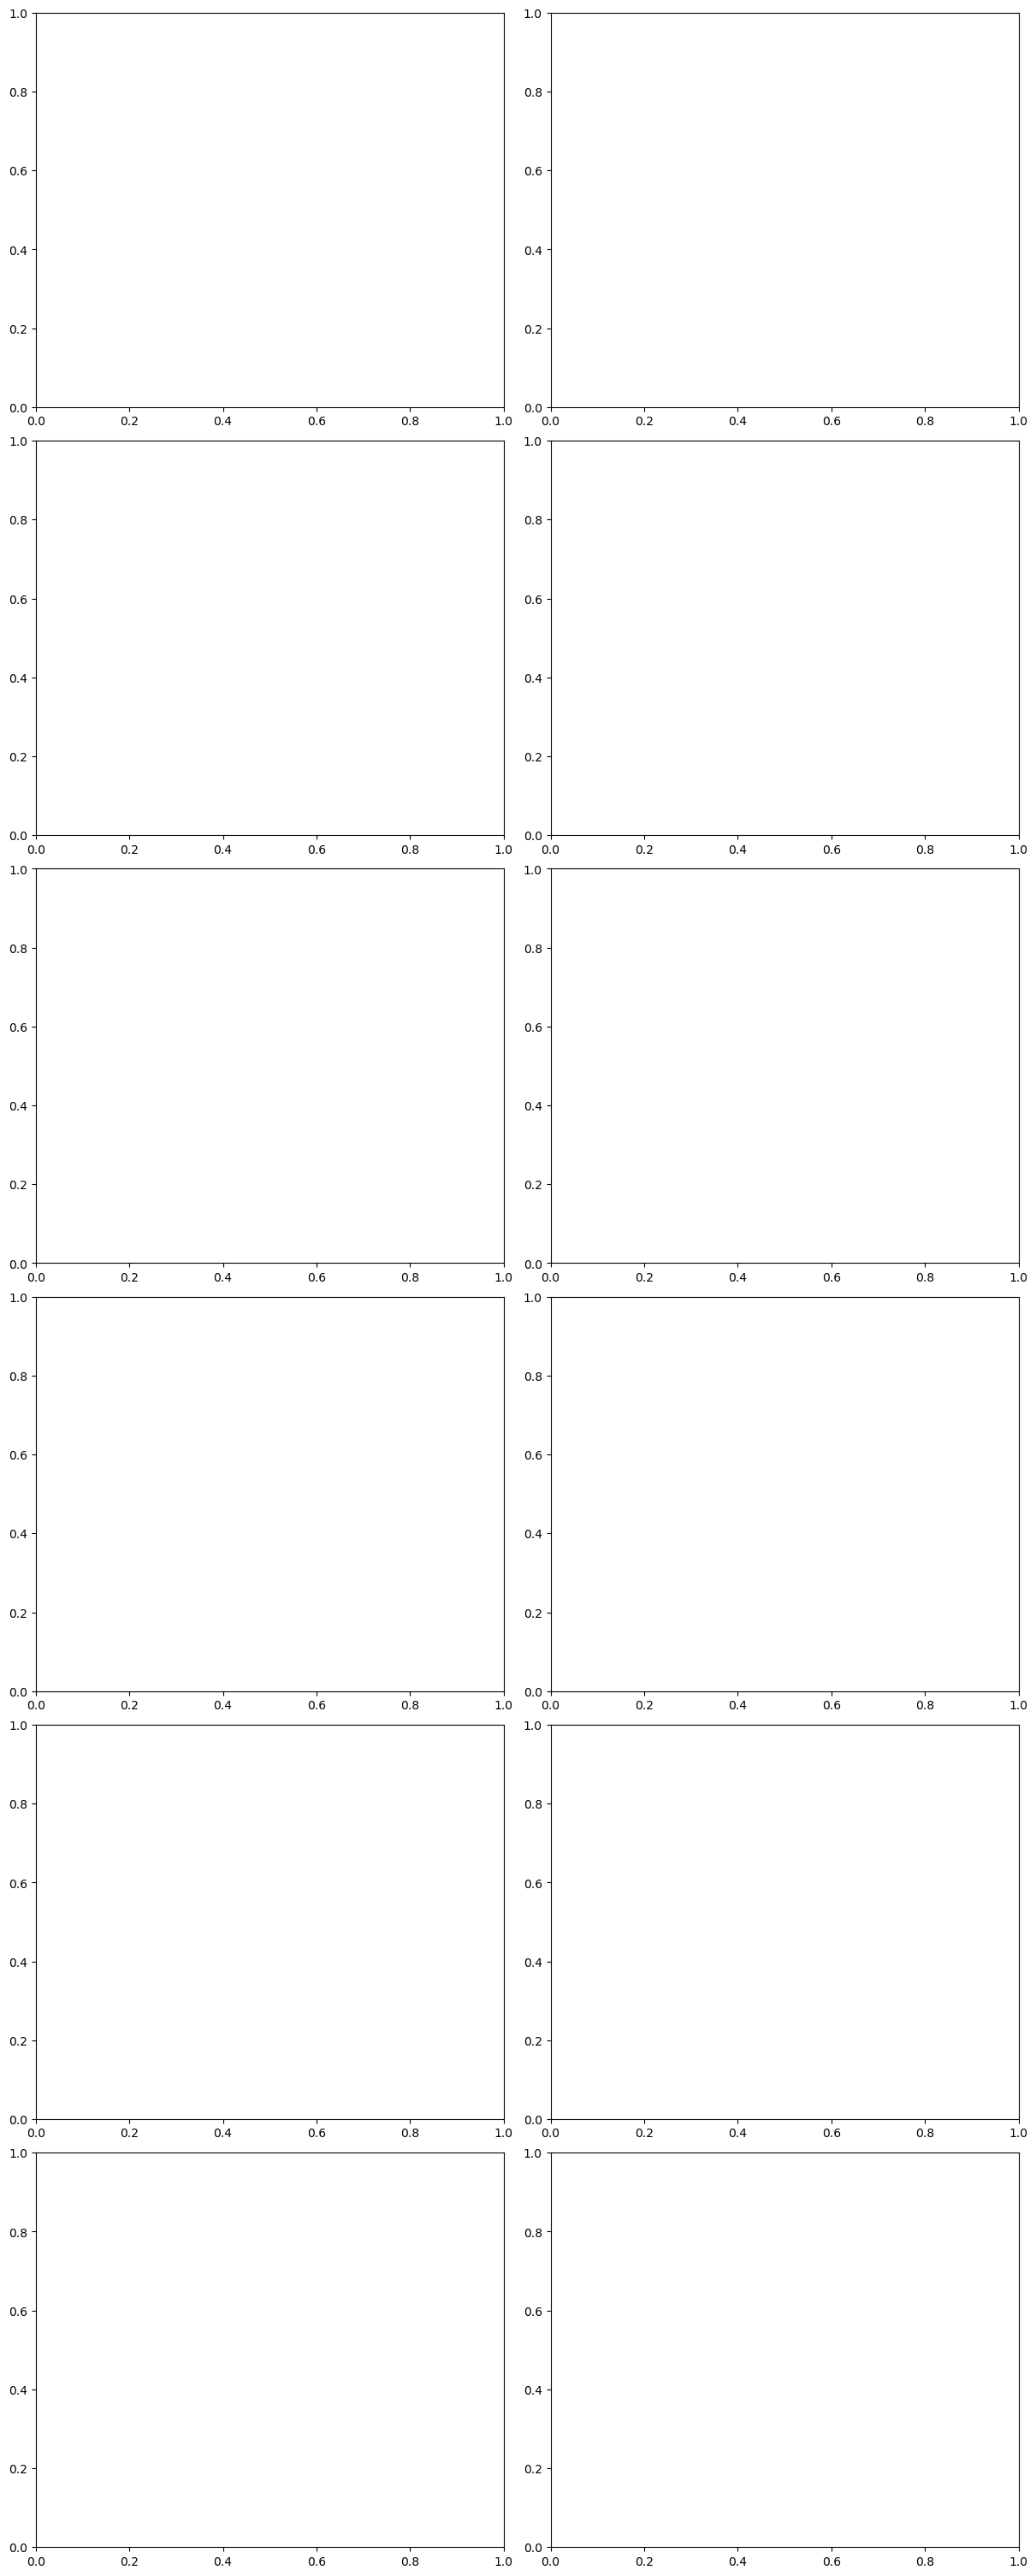

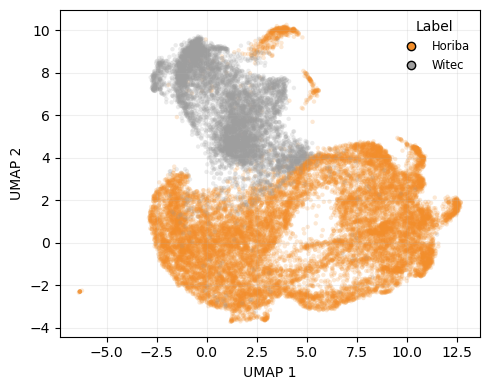

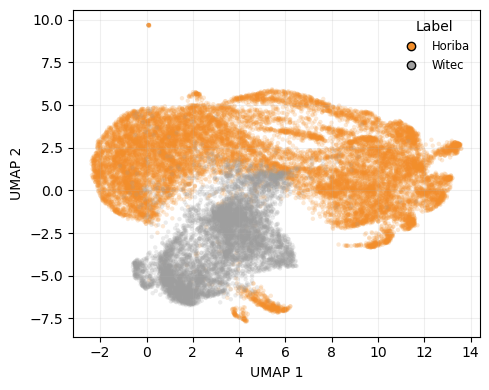

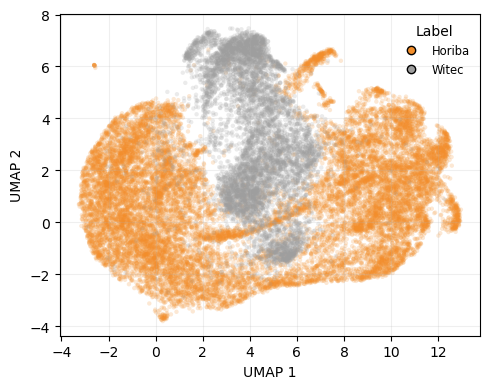

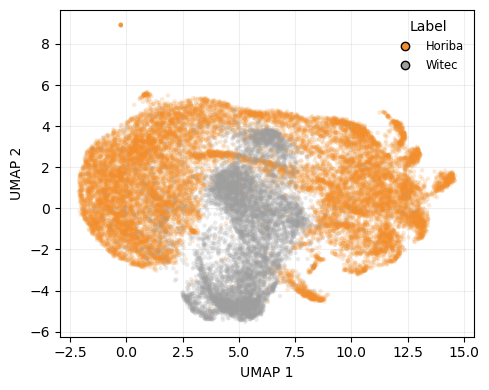

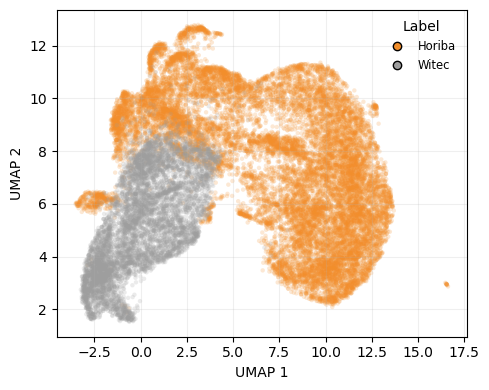

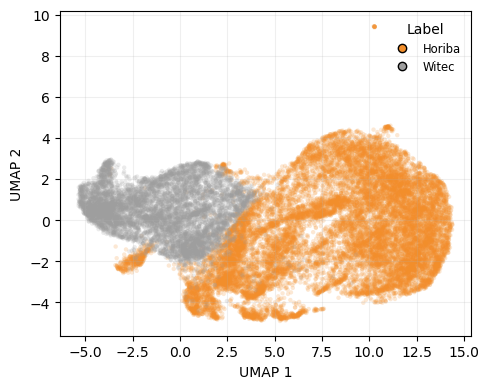

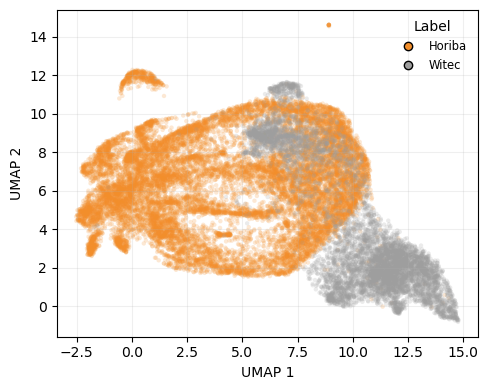

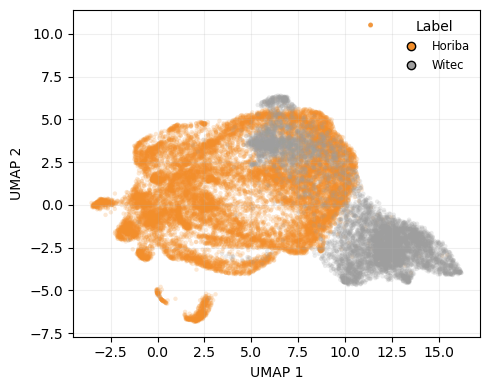

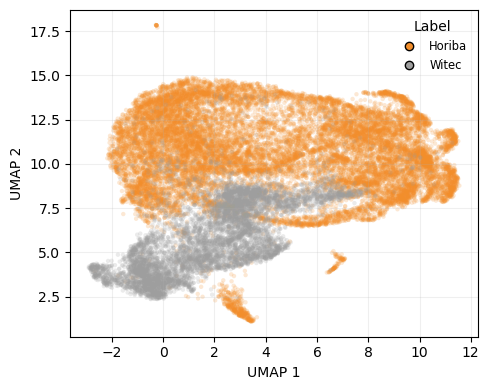

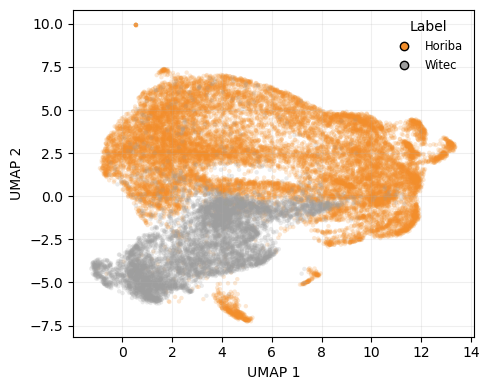

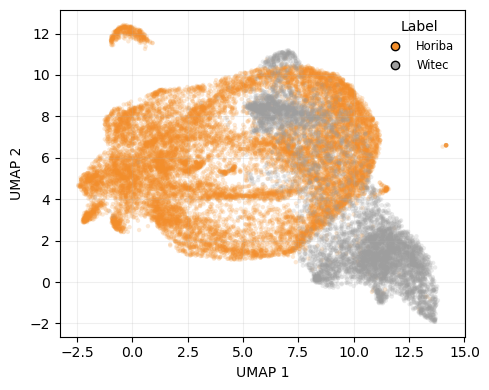

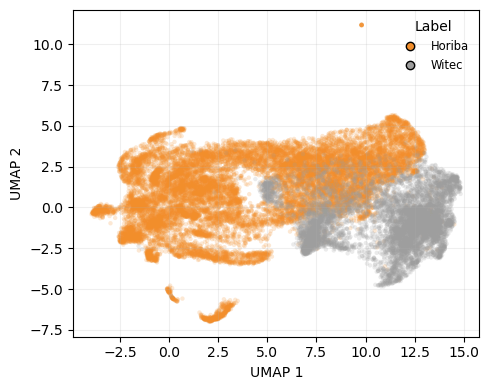

In [ ]:
# 使用某个物种计算映射，把其他物种的也映射过去
for i, label in enumerate(np.unique(y_witec)):
    mu_h = z_h_matched[y_horiba==label,:].mean(axis=0)
    mu_w = z_w_matched[y_witec==label,:].mean(axis=0)
    shift_vector = mu_w - mu_h
    z_h_mapped = z_h_matched + shift_vector
    z_w_mapped = z_w_matched - shift_vector
    Mod_Horiba = np.matmul(z_h_mapped, S_t)
    Mod_Witec = np.matmul(z_w_mapped, S_t)

    pca = PCA(n_components=20)  
    X_pca = pca.fit_transform(np.vstack((Mod_Horiba,X_witec)))
    umap_reducer = umap.UMAP( n_components=2, n_neighbors=50,  min_dist=0.01, spread=1, metric='cosine', random_state=42, a = 0.9922, b = 1.112) 
    h_umap = umap_reducer.fit_transform(X_pca)
    plot_UMAP( h_umap, Y_Mod_instru, os.path.join('/mnt/sda/gene/zhangym/VADER/VADER/Test_MCREC/1219_Test_Model', 'Umap_Finetune_Test.png') , width = 5, height = 4)

    pca = PCA(n_components=20)  
    X_pca = pca.fit_transform(np.vstack((X_horiba,Mod_Witec)))
    umap_reducer = umap.UMAP( n_components=2, n_neighbors=50,  min_dist=0.01, spread=1, metric='cosine', random_state=42, a = 0.9922, b = 1.112) 
    w_umap = umap_reducer.fit_transform(X_pca)
    plot_UMAP( w_umap, Y_Mod_instru, os.path.join('/mnt/sda/gene/zhangym/VADER/VADER/Test_MCREC/1219_Test_Model', 'Umap_Finetune_Test.png') , width = 5, height = 4)

In [ ]:
# 使用某个物种计算映射，把其他物种的也映射过去
for i, label in enumerate(np.unique(y_witec)):
    mu_h = z_h_matched[y_horiba==label,:].mean(axis=0)
    mu_w = z_w_matched[y_witec==label,:].mean(axis=0)
    shift_vector = mu_w - mu_h
    z_h_mapped = z_h_matched + shift_vector
    z_w_mapped = z_w_matched - shift_vector
    Mod_Horiba = np.matmul(z_h_mapped, S_t)
    Mod_Witec = np.matmul(z_w_mapped, S_t)
    np.save(f'../Augmentation/Cross-instrument/Generate_Spec/Mod_Horiba_{label}.npy',Mod_Horiba)
    np.save(f'../Augmentation/Cross-instrument/Generate_Spec/Mod_Witec_{label}.npy',Mod_Witec)


In [63]:
np.unique(y_witec)

array([0, 1, 2, 3, 4, 5])

In [62]:
type(z_h_matched)

numpy.ndarray

In [63]:
similar_S = [0,1,2,3,4,7,8,11,12,13]
similar_C = [1,2,8,17]
change_S = [1,2,8,17]
S_w_change = S_w[col_ind,:]
S_h_change = S_h
S_h_change[change_S,:] = S_w_change[change_S,:]
S_w_change[change_S,:] = S_h[change_S,:]
Mod_Horiba = np.matmul(z_h, S_w_change[col_ind,:])
Mod_Witec = np.matmul(z_w[:,col_ind], S_h_change)

In [68]:
Mod_Horiba = np.matmul(z_h, S_w[col_ind,:])
Mod_Witec = np.matmul(z_w[:,col_ind], S_h)

In [55]:
np.save('../Augmentation/Cross-instrument/Generate_Spec/Mod_Horiba.npy',Mod_Horiba)
np.save('../Augmentation/Cross-instrument/Generate_Spec/Mod_Witec.npy',Mod_Witec)

/home/gene/zhangym/.conda/envs/ID_PY390/lib/python3.9/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


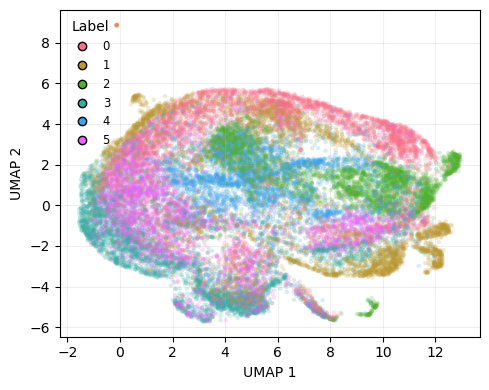

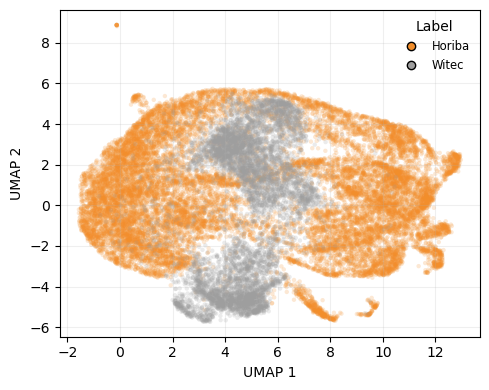

In [55]:
# Show datasets 
import umap 
from sklearn.decomposition import PCA
import numpy as np
import os

# X_Mod = np.vstack((X_horiba, Mod_Witec))
# X_Mod = np.vstack((Mod_Horiba, X_witec))
# X_Mod = np.vstack((X_horiba, X_witec))
Y_Mod = np.hstack((y_horiba, y_witec))
Y_Mod_instru = np.array(['Horiba'] * X_horiba.shape[0] + ['Witec'] * X_witec.shape[0] ) 

pca = PCA(n_components=20)  
X_pca = pca.fit_transform(np.vstack((X_horiba,Mod_Witec)))

umap_reducer = umap.UMAP( n_components=2, n_neighbors=50,  min_dist=0.01, spread=1, metric='cosine', random_state=42, a = 0.9922, b = 1.112) 
z_umap = umap_reducer.fit_transform(X_pca)

plot_UMAP( z_umap, Y_Mod, os.path.join('/mnt/sda/gene/zhangym/VADER/VADER/Test_MCREC/1219_Test_Model', 'Umap_Finetune_Test.png') , width = 5, height = 4)
plot_UMAP( z_umap, Y_Mod_instru, os.path.join('/mnt/sda/gene/zhangym/VADER/VADER/Test_MCREC/1219_Test_Model', 'Umap_Finetune_Test.png') , width = 5, height = 4)

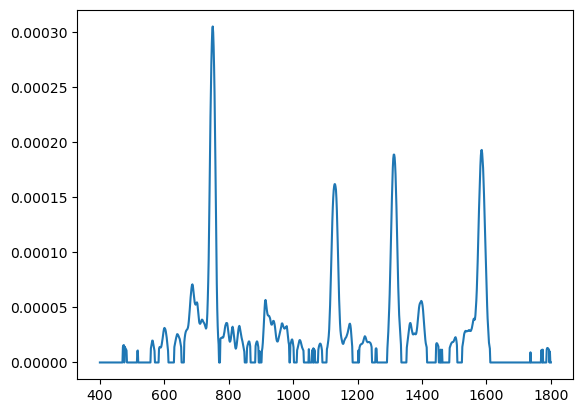

In [53]:
plt.plot(wave, S_h[5])